# Benchmark for Beginner Track

In [ ]:
# =========================================================
# 1. Import Libraries & Load Data
# =========================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# For our Deep Neural Network
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

#For splitting the training and testing data
from sklearn.model_selection import train_test_split 

# Some display settings for nicer graphs
plt.rcParams['figure.figsize'] = (10, 6)
sns.set_style('whitegrid')

# Load dataset
dataset_df = pd.read_csv('train_data.csv')
print("Data Loaded! Shape:", dataset_df.shape)
print(dataset_df.head())

# Load test data
test_df = pd.read_csv('test_data.csv')
print("Test Data Loaded! Shape:", test_df.shape)
print(test_df.head())


# 2.1: Drop columns we don't want or need from training data
# They might not directly help us predict in a simple DNN approach.
dataset_df = dataset_df.drop([
    'timestamp', 'patient_id',
    'address', 'city', 'state', 'postcode'
], axis=1)

test_df = test_df.drop([
    'timestamp', 'patient_id', 
    'address', 'city', 'state', 'postcode'
], axis=1)

In [ ]:
# =========================================================
# 2. Preprocessing
# =========================================================


# 2.1: Check for missing values
print("Missing values in training data:\n", dataset_df.isna().sum())
# print("Missing values in test data:\n", test_df.isna().sum())

# Example strategy: just drop rows with missing data.
# (Real-world might do more nuanced imputation.)
dataset_df = dataset_df.dropna()
# test_df = test_df.dropna()

# 2.2: Extract features (X) and labels (y) from the training set
X_all = dataset_df.drop('state_label', axis=1)
y_all = dataset_df['state_label']

# Perform the split (default is 75% train, 25% test)
X_train, X_test, y_train, y_test = train_test_split(
    X_all, 
    y_all,
    test_size=0.25,     # Size of the test set (0.25 = 25% of data)
    random_state=42,     # Set seed for reproducibility
    shuffle=True         # Shuffle the data before splitting
)

#2.4 Extract features (X) and labels (y) from the training set
print("Training Features shape:", X_train.shape)
print("Training Labels shape:", y_train.shape)


#2.4 Extract features (X) and labels (y) from the testing set
print("Training Features shape:", X_test.shape)
print("Training Labels shape:", y_test.shape)

In [ ]:
unique_states = y_train.unique()
num_classes = len(unique_states)
print("Unique state labels:", unique_states)
print("Number of classes:", num_classes)

# Sort them to create a mapping
unique_states_sorted = sorted(unique_states)
state_to_index = {state: i for i, state in enumerate(unique_states_sorted)}
print("State to Index mapping:", state_to_index)

# Convert our training labels to numerical indices
y_train_indices = y_train.map(state_to_index)

# One-hot encode the training labels
from tensorflow.keras.utils import to_categorical

y_train_encoded = to_categorical(y_train_indices, num_classes=num_classes)
print("y_train_encoded shape:", y_train_encoded.shape, 
      "Example one-hot vector:", y_train_encoded[0])


#Repeat for testing data
unique_states = y_test.unique()
num_classes = len(unique_states)
print("Unique state labels:", unique_states)
print("Number of classes:", num_classes)

# Sort them to create a mapping
unique_states_sorted = sorted(unique_states)
state_to_index = {state: i for i, state in enumerate(unique_states_sorted)}
print("State to Index mapping:", state_to_index)

# Convert our testing labels to numerical indices
y_test_indices = y_test.map(state_to_index)

y_test_encoded = to_categorical(y_test_indices, num_classes=num_classes)
print("y_train_encoded shape:", y_test_encoded.shape, 
      "Example one-hot vector:", y_test_encoded[0])

In [ ]:
from tensorflow.keras.regularizers import l2
import keras_tuner as kt
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping

def build_model(hp):
    model = Sequential()

    # Input layer with tunable units
    model.add(
        Dense(
            units=hp.Int('units_input', min_value=32, max_value=128, step=32),
            activation='relu',
            input_shape=(X_train.shape[1],)
        )
    )
    model.add(Dropout(hp.Float('dropout_input', min_value=0.1, max_value=0.5, step=0.1)))

    # Hidden layer 1 with tunable regularization
    model.add(
        Dense(
            units=hp.Int('units_hidden1', min_value=32, max_value=128, step=32),
            activation='relu',
            kernel_regularizer=l2(hp.Float('l2_hidden1', min_value=0.001, max_value=0.01, step=0.001))
        )
    )
    model.add(Dropout(hp.Float('dropout_hidden1', min_value=0.1, max_value=0.5, step=0.1)))

    # Hidden layer 2
    model.add(
        Dense(
            units=hp.Int('units_hidden2', min_value=32, max_value=128, step=32),
            activation='relu',
            kernel_regularizer=l2(hp.Float('l2_hidden2', min_value=0.001, max_value=0.01, step=0.001))
        )
    )
    model.add(Dropout(hp.Float('dropout_hidden2', min_value=0.1, max_value=0.5, step=0.1)))

    # Output layer for multi-class classification
    model.add(Dense(num_classes, activation='softmax'))

    # Compile the model with a tunable optimizer
    model.compile(
        optimizer=hp.Choice('optimizer', ['adam', 'sgd']),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

In [ ]:
# Initialize the tuner
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=1,
    directory='my_dir',
    project_name='dnn_tuning'
)

# **Tune for batch size as well**
tuner.search(
    X_train, 
    y_train_encoded, 
    validation_split=0.2, 
    epochs=10, 
    verbose=1,
    # Add a batch size search
    batch_size=kt.HyperParameters().Choice('batch_size', [32, 64, 128, 256, 512])
)

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best hyperparameters:", best_hps.values)

# Retrieve the best model
model = tuner.hypermodel.build(best_hps)


In [ ]:
import json

# Save the best hyperparameters to a JSON file
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Save the hyperparameters as a dictionary
with open("best_hyperparameters.json", "w") as f:
    json.dump(best_hps.values, f)

Epoch 1/500
28256/28256 ━━━━━━━━━━━━━━━━━━━━ 41s 1ms/step - accuracy: 0.8869 - loss: 0.3307 - val_accuracy: 0.8950 - val_loss: 0.2997
Epoch 2/500
28256/28256 ━━━━━━━━━━━━━━━━━━━━ 40s 1ms/step - accuracy: 0.8880 - loss: 0.3266 - val_accuracy: 0.8958 - val_loss: 0.2992
Epoch 3/500
28256/28256 ━━━━━━━━━━━━━━━━━━━━ 40s 1ms/step - accuracy: 0.8889 - loss: 0.3239 - val_accuracy: 0.8935 - val_loss: 0.2986
Epoch 4/500
28256/28256 ━━━━━━━━━━━━━━━━━━━━ 41s 1ms/step - accuracy: 0.8911 - loss: 0.3203 - val_accuracy: 0.8998 - val_loss: 0.2888
Epoch 5/500
28256/28256 ━━━━━━━━━━━━━━━━━━━━ 41s 1ms/step - accuracy: 0.8921 - loss: 0.3180 - val_accuracy: 0.9034 - val_loss: 0.2847
Epoch 6/500
28256/28256 ━━━━━━━━━━━━━━━━━━━━ 39s 1ms/step - accuracy: 0.8924 - loss: 0.3162 - val_accuracy: 0.8982 - val_loss: 0.2874
Epoch 7/500
28256/28256 ━━━━━━━━━━━━━━━━━━━━ 41s 1ms/step - accuracy: 0.8926 - loss: 0.3153 - val_accuracy: 0.9016 - val_loss: 0.2801
Epoch 8/500
28256/28256 ━━━━━━━━━━━━━━━━━━━━ 39s 1ms/step - ac

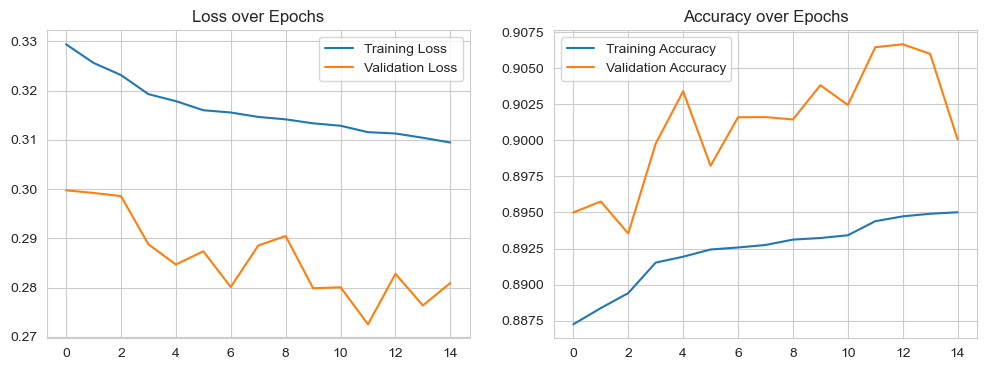

In [45]:
# Early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

best_batch_size = 256

# Train the model
history = model.fit(
    X_train,
    y_train_encoded,
    epochs=500,
    batch_size=best_batch_size,
    validation_split=0.2,
    verbose=1,
    callbacks=[early_stopping]
)

# Plotting training and validation performance
plt.figure(figsize=(12, 4))

# Plot training and validation loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title("Loss over Epochs")

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title("Accuracy over Epochs")

plt.show()

In [46]:
#  Extract the ID column from the test DataFrame
ids = test_df['ID']
# Remove the ID column to get only the 5 vital sign features (diastolic_bp, systolic_bp, heart_rate, respiratory_rate, oxygen_saturation)
X_test_features = test_df.drop('ID', axis=1)

# Generate predictions (probabilities) for the test set using the correct feature set
pred_probabilities = model.predict(X_test_features)

# Convert probabilities to predicted class indices
pred_class_indices = np.argmax(pred_probabilities, axis=1)

# Map back to original state labels (using the mapping from training)
index_to_state = {v: k for k, v in state_to_index.items()}
predicted_state_labels = [index_to_state[idx] for idx in pred_class_indices]

# Create a DataFrame with the ID and predicted_label columns
predictions_df = pd.DataFrame({
    'ID': ids,
    'predicted_label': predicted_state_labels
})

# Save the predictions to a CSV file
predictions_df.to_csv('predictions_tuned.csv', index=False)
print("Predictions saved to predictions.csv")

10170/10170 ━━━━━━━━━━━━━━━━━━━━ 3s 298us/step
Predictions saved to predictions.csv
